To run this jupyter-notebook, please make sure you are using python 3.8 and see the packages in the requirements.txt.

This file describes the experimental implementation for the Semantic subgraph (SS, our approach), 
and Non-semantic subgraph (NS, our baseline 2),
including set-up phase, 
running phase for the use case 1, 2, and 3, and Figure 3 (Deepwalk-SS, Deepwalk-NS). 


# Setup phase
## Packages Installation

In [ ]:
import time
import os
from itertools import product
import math
from collections import Counter


from lark import Lark, Transformer, v_args
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx
import numpy as np
import pandas as pd

import stellargraph
import tensorflow.random
from gensim.models import Word2Vec
from stellargraph.data import UniformRandomWalk, BiasedRandomWalk, UniformRandomMetaPathWalk
from stellargraph import StellarGraph, StellarDiGraph, datasets
from neo4j import GraphDatabase

import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn import cluster, datasets, metrics
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score

from scipy import interpolate
from scipy.spatial import ConvexHull
from sklearn.cluster import KMeans

## Regular Expressions

Regular expression grammar meant for creating succinct patterns through a graph. The grammar below must contain a NODE Identifier, which should correspond to the node label in the Neo4J database. 

Examples of valid grammar statements:

<i>"chemical_substance treats> disease"</i> -> this would search for any node with the label <b>chemical_substance</b> connected to nodes of type <b>disease</b> with an edge of type <i>treats</i>.

<i>"chemical_substance ? disease"</i> -> this would search for any node with the label <b>chemical_substance</b> connected to nodes of type <b>disease</b> with any edge.


In [2]:
regex_grammar = """
    start: node 
         | node (edge node)+
         | node "(" path ")"

    ?path: edge_node
         | path "|" edge_node   -> path_or 
    
    ?edge_node: edge node
         | "(" edge_node+ ")" 
         
    ?edge: attm
         | edge "|" attm        -> edge_or
         
    ?attm: EDGE_LABEL           -> edge
         | attm ">"             -> edge_right
         | attm "<"             -> edge_left
         | NULL                 -> edge_no_label
         | "(" edge ")"     
    
    ?node: atom
        | node "|" atom         -> node_or

    ?atom: NODE_LABEL           -> node
         | NODE_LABEL "*"       -> rep_from_0
         | NODE_LABEL "+"       -> rep_from_1
         | NULL                 -> node_no_label
         | "(" node ")"

    EDGE_LABEL: LABEL_STRING
    NODE_LABEL: LABEL_STRING
    NULL: "?"
    LCASE_LETTER: "a".."z"
    UCASE_LETTER: "A".."Z"
    DIGIT: "0".."9"

    LETTER: UCASE_LETTER | LCASE_LETTER | DIGIT | "_" | "-" | "`" | ":"
    LABEL_STRING: LETTER+ | "_" 

    %import common.CNAME -> NAME
    %import common.WS_INLINE
    %ignore WS_INLINE
"""

## Lark Parser
Converts a subgraph regular expression into a CYPHER query. 
These functions act on different triggers provided by the grammar above.

In [3]:
@v_args(inline=True)    # Affects the signatures of the methods
class CalculateTree(Transformer):
    node_idx = 0
    edge_idx = 0
        
    def node(self, name):
        self.node_idx += 1
        return "(n{}:".format(self.node_idx) + str(name) +")"
    
    def edge(self, name):
        self.edge_idx += 1
        return "-[r{}:".format(self.edge_idx) + str(name) +"]-"
    
    def node_no_label(self, name):
        self.node_idx += 1
        return "(n{}".format(self.node_idx) +")"
    
    def edge_no_label(self, name):
        self.edge_idx += 1
        return "-[r{}".format(self.edge_idx) +"]-"
    
    def edge_node(self, name1, name2):
        path = name1 + name2
        return path

    def edge_right(self, name):
        path = ''
        path = name 
        return path + ">"

    def edge_left(self, name):
        path = ''
        path = name 
        return "<" + path

    def rep_from_0(self, name):
        self.node_idx += 1
        path1 = "(n{}:".format(self.node_idx) + str(name) +")"
        path2 = "(n{}:".format(self.node_idx) + str(name) +")" + "--" + "(n{}:".format(self.node_idx+1) + str(name) +")"
        self.node_idx += 1
        return ['', path1, path2]

    def rep_from_1(self, name):
        self.node_idx += 1
        path1 = "(n{}:".format(self.node_idx) + str(name) +")"
        path2 = "(n{}:".format(self.node_idx) + str(name) +")" + "--" + "(n{}:".format(self.node_idx+1) + str(name) +")"
        self.node_idx += 1
        return [path1, path2]

    def node_or(self, name1, name2):
        return [name1, name2]
    
    def edge_or(self, name1, name2):
        return [name1, name2]
    
    def path_or(self, name1, name2):
        return [name1, name2]

In [136]:
# Permutes all possible pathways from the regular expression.
def extractPathways(parse_tree):
    all_elems = []
    mlist = []
    # Walks through the parse tree. If a node may have two or more labels
    # it is added to our collection as a list of all possible labels.
    for child in parse_tree.children:
        if type(child) == str:
            mlist.append([child])
        else:
            mlist.append(child)
            
    # We iterate through all possible combinations of node and edge labels
    # along the provided regex.
    for i in product(*mlist):
        all_elems.append(list(i))
        
    # Filter null characters out of node labels.
    pathways = []
    for i in all_elems:
        if('' in i): 
            idx = i.index("")
            i.pop(idx)
            i.pop(idx-1)
            pathways.append(i)
        else:
            pathways.append(i)
    return pathways

# Generates a CYPHER query for a regular expression. The first node in the regular expression will be 
# mapped onto the source_node_name.
def getQueries(source_node_name, regexes):
    all_queries = []
    subgraph_nodes = []
    # parse
    regex_parser = Lark(regex_grammar, parser='lalr',transformer=CalculateTree())
    parsed = regex_parser.parse(regexes)
    all_pathways = extractPathways(parsed)
    
    queryStr = ''
    final_idx = len(all_pathways)-1
    for i, path in enumerate(all_pathways):
        
        if(path[-1]==''):path[-1]
        start_node_num = path[0].split(":")[0].split("(")[1].split(")")[0]
        query = "MATCH p1="
        query += ''.join(str(elem) for elem in path)   
        query += " WHERE %s.name =" % start_node_num
        query += " '%s'" % source_node_name
        
        # add conditions to the node names if repeated types in the path
        add_where = ""
        repeated = []
        for j in path:
            if ":" in j: # if type is given
                if j.split(":")[1] in repeated: # if type is repeated
                    if ")" in j: # if it is a node
                        prev = path[repeated.index(j.split(":")[1])].split(":")[0].split("(")[1]
                        current = j.split(":")[0].split("(")[1]
                        add_where += " AND %s" % prev
                        add_where += " <> %s" % current
                repeated.append(j.split(":")[1])
            else:
                repeated.append("?")                
            
        query += add_where
        query += " RETURN p1 LIMIT 10000" 
        if(i==final_idx): queryStr += query
        else: queryStr += query + " UNION "
        
#         print(queryStr)
    
    return queryStr

In [5]:
def parsing(regexes):
    # parse
    regex_parser = Lark(regex_grammar, parser='lalr',transformer=CalculateTree())
    reg = regex_parser.parse
    parsed = reg(regexes)
    all_elems = extractPathways(parsed)

    
    llink = []
    for i in all_elems:
        Link = []
        for j in i:
            if ':' in j:
                if '(' in j:
                    nodes = j.split(':',1)[1].split(')')[0]
                    Link.append(nodes)
                if '[' in j:
                    edges = j.split(':',1)[1].split(']')[0]
                    Link.append(edges)
            else:
                edges = '?'
                Link.append(edges)
#         print(Link)

        for i in range(math.floor(len(Link)/2)):
            #print(i)
            if i == 0:
                llink.append(Link[i:(i+3)])
            else:
                llink.append(Link[(i*2):(i*2)+3])

    return llink

## Functions to Retrieve Subgraphs from a Neo4j database
The function getSubgraph_neo4j is used to obtain Semantic Subgraphs, 
and the function querySubgraph is used to obtain Non-semantic Subgraphs.
The function buildSubgraphDictonaryForNodes is used to find a list of Semantic Subgraphs if a list of nodes is given.

In [10]:
def getSubgraph_neo4j(graph_uri, source_node_name, regexes, compared_labels = None):
    
    queryStr = getQueries(source_node_name, regexes)    
    driver = GraphDatabase.driver(graph_uri)
    
    user_labels = []
    for ele in parsing(regexes):
        user_labels += ele
    user_labels = list(set(user_labels))
            
    with driver.session() as session:
        result = session.run(queryStr)
        d = {}
        join_values = []
        for i in result.graph().nodes:
            node_name = i['name']
            if node_name not in join_values:
                #print('labels = ',list(i.labels))
                if len(i.labels)>1:
                    for m in i.labels:
                        
                        if(":" in m):
                            mm = "`" + m + "`"
                            m = mm
                        
                        if m in user_labels:
                            node_type = m
                        
                        ### for multiple-labeled graph using regex "? ? ?"
                        
                        elif compared_labels != None:
                            if m in compared_labels:
                                node_type = m
                        else:
                            node_type = list(i.labels)[0]
                        ###
                else:
                    node_type = list(i.labels)[0]
                s = d.get(node_type,set())

                if type(node_name) == list:
                    s.add(node_name[0])
                else:
                    s.add(node_name)

                d[node_type] = s
            join_values.append(node_name)

        rels = set()
        for i in result.graph().relationships:
            start = i.start_node["name"]
            end = i.end_node["name"]

            if type(start) == list:
                start_n = start[0]
            else:
                start_n = start

            if type(end) == list:
                end_n = end[0]
            else:
                end_n = end

            rel_type = i.type
            rels.add((start_n, end_n, rel_type))

    raw_nodes = d        
    edges = pd.DataFrame.from_records(list(rels),columns=["source","target","label"])

    data_frames = {}
    for k in d:
        node_names = list(d[k])
        df = pd.DataFrame({"name":node_names}).set_index("name")
        data_frames[k] = df

    sg = StellarDiGraph(data_frames,edges=edges, edge_type_column="label")
   
    return sg

# Helper function. Constructs a dictonary; the keys are node names provided in
# node_list. The values are the semantic subgraphs constructed using the 
# parameters G, semantic_query, and compare_labels.
def buildSubgraphDictonaryForNodes(node_list, G, semantic_query, compared_labels):
    subGs = {}
    for node in node_list:
        subG = getSubgraph_neo4j(G, node, semantic_query, compared_labels)
        subGs[node] = subG
#         print(node)
#         print(infoDict(subG))
    return subGs

In [7]:
# Returns counts of all node by labels in graph and all relationships by types.
def infoDict(subG):
    Info = {}
    for i in subG.info().split('\n'):
        if '[' in i:
            temp = i.rsplit(':',1)
            text = temp[0].strip()
            num = temp[1].split('[')[1].split(']')[0]
            Info[text] = num
    return Info

## Functions to Generate Random Walks and Embeddings with Regular Expressions 
### (our approach)

In [8]:
#Generates random walks for various methods.
def compactWalks(subgraph_dict, node_list, method, l, r, metapath = None):
    Walks = []
    for node in node_list:
        subG = subgraph_dict[node]
        # DeepWalk
        if method == 'deepwalk':
            rw = UniformRandomWalk(subG) #BiasedRandomWalk(G)
            walks = rw.run(
                nodes= [node],#list(G.nodes()),  # root nodes
                length = l,#adj_wlength,  # maximum length of a random walk
                n = r #,  # number of random walks per root node
                #seed = 1
            )

        # Node2Vec
        elif method == 'node2vec':
            rw = BiasedRandomWalk(subG)
            walks = rw.run(
                nodes= [node],  # root nodes
                length = l,  # maximum length of a random walk
                n = r,  # number of random walks per root node
                p = 0.25,  # Defines (unormalised) probability, 1/p, of returning to source node
                q = 0.25#,  # Defines (unormalised) probability, 1/q, for moving away from source node
                #seed = 5
            )

        #Metapath2vec
        elif method == 'metapath2vec':
            rw = UniformRandomMetaPathWalk(subG)
            walks = rw.run(
                nodes= [node],#list(G.nodes()),  # root nodes
                length = l,  # maximum length of a random walk
                n = r,  # number of random walks per root node
                metapaths = metapath#,
                #seed = 5
            )

        # append walks
        for w in walks:
            Walks.append(w)
            
    return Walks

# find semantic ratio for Walks provided.
def sematicRatio_walks(regexes, Walks, subGs):
    num = 0
    den = 0

    # parse
    llink = parsing(regexes)
    print(llink)

    # matching process
    for i in Walks:     
        # matching nodes
        for j in i:
            res = []
            # find node type for j
            # if two or more graphs
            if type(subGs) == dict: 

                nodes = []
                for n in subGs.keys():
                    nodes.append(n)
                
                for n in nodes:
                    if j in subGs[n].nodes():
                        node_label = subGs[n].node_type(j)
                        break

            # if only one graph        
            else: 
                node_label = subGs.node_type(j)

            for l in llink:
                if node_label in l:
                    res.append('Y')
                    break
                else:
                    res.append('N')
            
            # counting how many signals in nodes
            if('Y' in res):
                num += 1
            den += 1
        
        # matching edges
        for j in range(len(i)-1):
            res = []
            node1 = i[j]
            node2 = i[j+1]
            
            # if two graphs
            if type(subGs) == dict: 
                for n in nodes:
                    if (node1, node2) in subGs[n].edges():
                        loc = subGs[n].edges().index((node1, node2))
                        edge_label = subGs[n].edges(' ')[loc][2]
                        break
                    elif (node2, node1) in subGs[n].edges():
                        loc = subGs[n].edges().index((node2, node1))
                        edge_label = subGs[n].edges(' ')[loc][2]
                        break

            # if one graph
            else:
                if (node1, node2) in subGs.edges():
                    loc = subGs.edges().index((node1, node2))
                    edge_label = subGs.edges(' ')[loc][2]
                elif (node2, node1) in subGs.edges():
                    loc = subGs.edges().index((node2, node1))
                    edge_label = subGs.edges(' ')[loc][2]
            
            for l in llink:
                if edge_label in l:
                    res.append('Y')
                    break
                else:
                    res.append('N')      
            # counting how many signals in edges
            if('Y' in res):
                num += 1
            den += 1
    print(num, den)
    return round(num/den,4)


# Generates a model with embeddings from provided collection of Walks.
def buildModel(Walks):
    str_walks = [[str(n) for n in walk] for walk in Walks]
    model = Word2Vec(str_walks, size=128, window=10, min_count=0, sg=1, workers=2, iter=5)
    return model

## Functions to Evaluate the Embeddings obtained from Semantic Subgraphs

In [153]:
# Computes various benchmarks for a machine learning models.
def evaluate(model, subgraph_dict, node_list1, node_list2):
    evaluate_dict = {}
    hit_at_1_in_list = 0
    hit_at_3_in_list = 0
    hit_at_5_in_list = 0
    mrr_in_list = 0
    
    Node_List = node_list1 + node_list2
    
    for n in node_list1:
#         print("==", n, "==")
        n_all = 0
        num_in_list = 0
        rank_in_list = 0

        for i in model.wv.most_similar(n, topn = 20000):
            n_all += 1

            for j in Node_List:
                if i[0] in subgraph_dict[j].nodes():
                    nodeType = subgraph_dict[j].node_type(i[0])
                    break

            if i[0] in Node_List:
                num_in_list += 1

            if i[0] == node_list2[node_list1.index(n)]:
#                 print('drugs* ',num_in_list)
                # test: include only drugs in list
                rank_in_list = num_in_list
                if rank_in_list == 1:
                    hit_at_1_in_list += 1
                if rank_in_list <= 3:
                    hit_at_3_in_list += 1
                if rank_in_list <= 5:
                    hit_at_5_in_list += 1
                mrr_in_list += 1/rank_in_list

    HIT1 = round(hit_at_1_in_list/len(node_list1),4)
    HIT3 = round(hit_at_3_in_list/len(node_list1),4)
    HIT5 = round(hit_at_5_in_list/len(node_list1),4)
    MRR = round(mrr_in_list/len(node_list1),4)
    
    evaluate_dict['HIT@1'] = HIT1
    evaluate_dict['HIT@3'] = HIT3
    evaluate_dict['HIT@5'] = HIT5
    evaluate_dict['MRR'] = MRR
    
    return evaluate_dict

# Running Phase 
## Example Run

In [11]:
## Hetionet (Drug)
# given G, node_List, user input regex, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://neo4j.het.io" 

# node_list = a list of nodes of interest
node_list = ['Canagliflozin', 'Dapagliflozin','Dexamethasone', 'Betamethasone','Lapatinib', 'Afatinib',
            'Captopril', 'Enalapril','Losartan', 'Valsartan','Nifedipine', 'Felodipine',
            'Simvastatin', 'Atorvastatin','Alendronate', 'Incadronate','Citalopram', 'Escitalopram']

# semantic_query = user input regular expressions
semantic_query = "Compound BINDS_CbG Gene ASSOCIATES_DaG< Disease"

# metapaths {if metapath2vec is used}   
metapaths = [['Compound','Gene','Disease', 'Gene', 'Compound']]

# True node-pairs to evaluate
node_pair1 = ['Canagliflozin', 'Dexamethasone','Lapatinib', 
                'Captopril','Losartan', 'Nifedipine', 
                'Simvastatin', 'Alendronate', 'Citalopram']
node_pair2 = ['Dapagliflozin','Betamethasone','Afatinib',
                'Enalapril','Valsartan','Felodipine',
                'Atorvastatin','Incadronate','Escitalopram']

# subgraph_dict = a list (dictionary object here) of semantic subgraphs
subgraph_dict = buildSubgraphDictonaryForNodes(node_list, G, semantic_query, None)

# E.g., here we use embedding method(m) = deepwalk, walk_length(l) = 80, num_walk(r) = 5
Walks = compactWalks(subgraph_dict, node_list, 'deepwalk', 80, 5)
model = buildModel(Walks)

# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (model.wv.vectors)

evaluate(model, subgraph_dict, node_pair1, node_pair2)

{'HIT@1': 0.6667, 'HIT@3': 0.7778, 'HIT@5': 0.7778, 'MRR': 0.7262}

## Experiment
### Use case 1 -- Drug Clustering

We perform cluster analysis for drugs in use case 1. 
To better implement the process, we created a function -- "Clustering" to conduct the process iteratively 
and directly output the average NMI. 
Note that we have to build out semantic subgraphs (SS) and non-semantic subgraphs (NS) first 
before conducting the experiment.

In [12]:
## process of experiment use case 1 to compute average NMI
def Clustering(subgraph_dict, node_list, label_true, m, metapath = None):
    NMI = []
    for i in range(0,10): # the times you want to run can be altered here
        Walks = compactWalks(subgraph_dict, node_list, m, 80, 20, metapath)
        model = buildModel(Walks)
        # Retrieve node embeddings and corresponding subjects
        node_ids = model.wv.index2word  # list of node IDs
        node_embeddings = (model.wv.vectors)    

        # clustering
        elist = []
        for i in node_list:
            elist.append(node_embeddings[node_ids.index(i)])
        node_embeddings_drug = np.array(elist)
        X = node_embeddings_drug
        kmeans_fit = cluster.KMeans(n_clusters = 10).fit(X)
        cluster_labels = kmeans_fit.labels_
        label_pred = cluster_labels
        nmi = normalized_mutual_info_score(label_true, label_pred)
        NMI.append(nmi)
        
    return round(sum(NMI)/len(NMI),4)

In [13]:
## Hetionet (Drug) 
# given G, node_List, user input regex, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://neo4j.het.io" 

# node_list = a list of nodes of interest

node_list = ['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone',
'Canagliflozin', 'Dapagliflozin', 
'Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib',
'Captopril', 'Enalapril', 'Benazepril', 'Lisinopril',
'Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan',
'Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine',
'Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin',
'Alendronate', 'Incadronate', 'Zoledronate',
'Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline',
'Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']
label_true = [0,0,0,0,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,8,8,8,8,8,9,9,9,9] 

# biulding Subgraphs (SS & NS)
subGsHetioDrugSS = buildSubgraphDictonaryForNodes(node_list, G, semantic_query, None)
subGsHetioDrugNS = buildSubgraphDictonaryForNodes(node_list, G, "Compound ? ? ? ?", None)

In [14]:
# drug clustering result for SS and NS on Hetionet
subgraph_dict_SS = subGsHetioDrugSS
subgraph_dict_NS = subGsHetioDrugNS

print("Drug clustering result for SS and NS on Hetionet:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    nmi = Clustering(subgraph_dict_SS, node_list, label_true, m, metapath = metapaths)
    print("SS-"+ m, ":",nmi)
    nmi = Clustering(subgraph_dict_NS, node_list, label_true, m, metapath = metapaths)
    print("NS-"+ m, ":",nmi)

Drug clustering result for SS and NS on Hetionet:
SS-deepwalk : 0.712
NS-deepwalk : 0.5937
SS-node2vec : 0.7347
NS-node2vec : 0.5705
SS-metapath2vec : 0.7444
NS-metapath2vec : 0.4278


The results will not be exactly the same as the method involves randomness; 
however, the values should be close to the published results, 
given that the input KG (provided graph URL) is not updated too much.

In [15]:
## ROBOKOP (Drugs)
# given G, node_List, user input regex, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://robokopkg.renci.org" 

# # node_list = a list of nodes of interest
node_list = ['Fluoxetine', 'Paroxetine', 'Sertraline',
            'Felodipine', 'Isradipine', 'Nifedipine',
            'Nilotinib', 'Bosutinib', 'Ponatinib',
            'Dexamethasone', 'Betamethasone', 'Desoximetasone',
            'Promethazine', 'Diphenhydramine', 'Chloropyramine',
            'Omeprazole', 'Pantoprazole',
            'Norethindrone', 'Levonorgestrel',
            'Apraclonidine', 'Brimonidine',
            'Glyburide', 'Tolbutamide', 
            'Simvastatin', 'Lovastatin', 'Pravastatin'
            ] 

label_true = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,6,6,7,7,8,8,9,9,9] # for clustering

# semantic_query = user input regular expressions
semantic_query = "`biolink:ChemicalEntity` ? `biolink:Gene` `biolink:causes` `biolink:DiseaseOrPhenotypicFeature`" 

# metapaths {if metapath2vec is used}   
metapaths = [['`biolink:ChemicalEntity`', '`biolink:Gene`', '`biolink:DiseaseOrPhenotypicFeature`', '`biolink:Gene`', '`biolink:ChemicalEntity`']]

# compared_labels {only for database includes multiple labels for nodes}
compared_label = ["`biolink:ChemicalEntity`", "`biolink:Gene`", "`biolink:DiseaseOrPhenotypicFeature`"]

# True node-pairs to evaluate
node_pair1 = ['Fluoxetine','Felodipine','Nilotinib','Dexamethasone','Promethazine',
              'Omeprazole','Norethindrone','Apraclonidine',
              'Glyburide',
              'Simvastatin']
node_pair2 = ['Paroxetine','Isradipine','Bosutinib','Betamethasone','Diphenhydramine',
              'Pantoprazole','Levonorgestrel','Brimonidine',
              'Tolbutamide',
              'Lovastatin'] 

# biulding Subgraphs (SS & NS)
subGsRobokopDrugSS = buildSubgraphDictonaryForNodes(node_list, G, semantic_query, compared_label)
subGsRobokopDrugNS = buildSubgraphDictonaryForNodes(node_list, G, "`biolink:ChemicalEntity` ? ? ? ?", compared_label)

In [16]:
# drug clustering result for SS and NS on ROBOKOP
subgraph_dict_SS = subGsRobokopDrugSS
subgraph_dict_NS = subGsRobokopDrugNS

print("Drug clustering result for SS and NS on ROBOKOP:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    nmi = Clustering(subgraph_dict_SS, node_list, label_true, m, metapath = metapaths)
    print("SS-"+ m, ":",nmi)
    nmi = Clustering(subgraph_dict_NS, node_list, label_true, m, metapath = metapaths)
    print("NS-"+ m, ":",nmi)

Drug clustering result for SS and NS on ROBOKOP:
SS-deepwalk : 0.8032
NS-deepwalk : 0.6565
SS-node2vec : 0.8118
NS-node2vec : 0.6664
SS-metapath2vec : 0.7707
NS-metapath2vec : 0.6348


Note that the current version of ROBOKOP has been updated a lot, 
and thus the results now seem not very close to the results we put in the published paper for ROBOKOP. 
However, the performance of SS is still better than the performance of NS.
(Same for the use case 2 and 3.)

## Use Case 2 -- Drug Prediction
We perform link prediction for drug-pairs in use case 2. 
To better implement the process, we created a function -- "PairPrediction" to conduct the process iteratively and directly output the average MRR & Hits@k. 
Note that in this use case, we can use the same subgraph_dict 
that we created for use case 1 as the nodes of interest here are included in the use case 1.

In [20]:
## process of experiment use case 2, 3 to compute average MRR & Hits@k
def PairPrediction(subgraph_dict, node_list, node_pair1, node_pair2, m, metapath = None):
    metrics = []
    average_dict = {}
    for i in range(0,10): # the times you want to run can be altered here
        Walks = compactWalks(subgraph_dict, node_list, m , 80, 20, metapath)
        model = buildModel(Walks)
        # Retrieve node embeddings and corresponding subjects
        node_ids = model.wv.index2word  # list of node IDs
        node_embeddings = (model.wv.vectors)    
        mrr_hit = evaluate(model, subgraph_dict, node_pair1, node_pair2)        
        metrics.append(mrr_hit)
    
    HIT1 = round(sum(item.get('HIT@1',0) for item in metrics) / len(metrics),4)
    HIT3 = round(sum(item.get('HIT@3',0) for item in metrics) / len(metrics),4)
    HIT5 = round(sum(item.get('HIT@5',0) for item in metrics) / len(metrics),4)
    MRR = round(sum(item.get('MRR',0) for item in metrics) / len(metrics),4)
    
    average_dict['HIT@1'] = HIT1
    average_dict['HIT@3'] = HIT3
    average_dict['HIT@5'] = HIT5
    average_dict['MRR'] = MRR
        
    return average_dict

In [21]:
# drug pair prediction result for SS and NS on Hetionet
subgraph_dict_SS = subGsHetioDrugSS
subgraph_dict_NS = subGsHetioDrugNS

# Reload the needed inputs (node_list, node_pair1, node_pair2, metapath) for Hetio drug-pairs
node_list = ['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone',
'Canagliflozin', 'Dapagliflozin', 
'Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib',
'Captopril', 'Enalapril', 'Benazepril', 'Lisinopril',
'Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan',
'Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine',
'Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin',
'Alendronate', 'Incadronate', 'Zoledronate',
'Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline',
'Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']

node_pair1 = ['Canagliflozin', 'Dexamethasone','Lapatinib', 
                'Captopril','Losartan', 'Nifedipine', 
                'Simvastatin', 'Alendronate', 'Citalopram']
node_pair2 = ['Dapagliflozin','Betamethasone','Afatinib',
                'Enalapril','Valsartan','Felodipine',
                'Atorvastatin','Incadronate','Escitalopram']

metapaths = [['Compound','Gene','Disease', 'Gene', 'Compound']]


print("Drug-pair prediction result for SS and NS on Hetionet:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    metrics = PairPrediction(subgraph_dict_SS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("SS-"+ m, ":",metrics)
    metrics = PairPrediction(subgraph_dict_NS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("NS-"+ m, ":",metrics)

Drug-pair prediction result for SS and NS on Hetionet:
SS-deepwalk : {'HIT@1': 0.7889, 'HIT@3': 0.8889, 'HIT@5': 0.9889, 'MRR': 0.8519}
NS-deepwalk : {'HIT@1': 0.4111, 'HIT@3': 0.6111, 'HIT@5': 0.7445, 'MRR': 0.5549}
SS-node2vec : {'HIT@1': 0.8111, 'HIT@3': 0.8778, 'HIT@5': 0.9778, 'MRR': 0.867}
NS-node2vec : {'HIT@1': 0.4, 'HIT@3': 0.5667, 'HIT@5': 0.7, 'MRR': 0.5275}
SS-metapath2vec : {'HIT@1': 0.8111, 'HIT@3': 0.9778, 'HIT@5': 1.0, 'MRR': 0.8889}
NS-metapath2vec : {'HIT@1': 0.1, 'HIT@3': 0.3888, 'HIT@5': 0.3888, 'MRR': 0.2846}


In [22]:
# drug pair prediction result for SS and NS on ROBOKOP
subgraph_dict_SS = subGsRobokopDrugSS
subgraph_dict_NS = subGsRobokopDrugNS

# Reload the needed inputs (node_list, node_pair1, node_pair2, metapath) for Robokop drug-pairs
node_list = ['Fluoxetine', 'Paroxetine', 
            'Felodipine', 'Isradipine', 
            'Nilotinib', 'Bosutinib', 
            'Dexamethasone', 'Betamethasone', 
            'Promethazine', 'Diphenhydramine', 
            'Omeprazole', 'Pantoprazole',
            'Norethindrone', 'Levonorgestrel', 
            'Apraclonidine', 'Brimonidine', 
            'Glyburide', 'Tolbutamide', 
            'Simvastatin', 'Lovastatin'
            ] 

node_pair1 = ['Fluoxetine','Felodipine','Nilotinib','Dexamethasone','Promethazine',
              'Omeprazole','Norethindrone','Apraclonidine',
              'Glyburide',
              'Simvastatin']
node_pair2 = ['Paroxetine','Isradipine','Bosutinib','Betamethasone','Diphenhydramine',
              'Pantoprazole','Levonorgestrel','Brimonidine',
              'Tolbutamide',
              'Lovastatin'] 

metapaths = [['`biolink:ChemicalEntity`', '`biolink:Gene`', '`biolink:DiseaseOrPhenotypicFeature`', '`biolink:Gene`', '`biolink:ChemicalEntity`']]


print("Drug-pair prediction result for SS and NS on ROBOKOP:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    metrics = PairPrediction(subgraph_dict_SS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("SS-"+ m, ":",metrics)
    metrics = PairPrediction(subgraph_dict_NS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("NS-"+ m, ":",metrics)

Drug-pair prediction result for SS and NS on ROBOKOP:
SS-deepwalk : {'HIT@1': 0.64, 'HIT@3': 0.78, 'HIT@5': 0.86, 'MRR': 0.733}
NS-deepwalk : {'HIT@1': 0.33, 'HIT@3': 0.43, 'HIT@5': 0.48, 'MRR': 0.428}
SS-node2vec : {'HIT@1': 0.6, 'HIT@3': 0.75, 'HIT@5': 0.83, 'MRR': 0.7031}
NS-node2vec : {'HIT@1': 0.32, 'HIT@3': 0.42, 'HIT@5': 0.48, 'MRR': 0.4206}
SS-metapath2vec : {'HIT@1': 0.55, 'HIT@3': 0.7, 'HIT@5': 0.81, 'MRR': 0.6605}
NS-metapath2vec : {'HIT@1': 0.2, 'HIT@3': 0.3, 'HIT@5': 0.6, 'MRR': 0.3374}


## Use Case 3 -- Disease Prediction

We perform link prediction for disease-pairs in use case 3. 
Same as use case 2, we use "PairPrediction" to conduct the process and output the average MRR & Hits@k. 
Note that in this use case, we should create subgraph_dict.

In [23]:
## Hetionet (Disease)
# given G, node_List, user input regex, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://neo4j.het.io" 

# node_list = a list of nodes of interest
node_list = ["hypertension","coronary artery disease",
"endogenous depression","panic disorder",
"schizophrenia",
"endogenous depression",
"pancreatic cancer","lung cancer",
"breast cancer","ovarian cancer",
"bipolar disorder","endogenous depression",
"stomach cancer","prostate cancer",
"migraine","epilepsy syndrome"]

# semantic_query = user input regular expressions
semantic_query = "Disease ASSOCIATES_DaG> Gene BINDS_CbG Compound"

# metapaths {if metapath2vec is used}   
metapaths = [['Disease', 'Gene', 'Compound', 'Gene', 'Disease']]

# True node-pairs to evaluate
node_pair1 = ["hypertension","endogenous depression","schizophrenia","endogenous depression","pancreatic cancer",
              "breast cancer","bipolar disorder","bipolar disorder","stomach cancer","migraine"]


node_pair2 = ["coronary artery disease","panic disorder","panic disorder","panic disorder","lung cancer",
              "ovarian cancer","endogenous depression","panic disorder","prostate cancer","epilepsy syndrome"]

# biulding Subgraphs (SS & NS)
subGsHetioDiseaseSS = buildSubgraphDictonaryForNodes(node_list, G, semantic_query, None)
subGsHetioDiseaseNS = buildSubgraphDictonaryForNodes(node_list, G, "Disease ? ? ? ?", None)

In [24]:
# disease pair prediction result for SS and NS on Hetionet
subgraph_dict_SS = subGsHetioDiseaseSS
subgraph_dict_NS = subGsHetioDiseaseNS

print("Disease-pair prediction result for SS and NS on Hetionet:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    metrics = PairPrediction(subgraph_dict_SS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("SS-"+ m, ":",metrics)
    metrics = PairPrediction(subgraph_dict_NS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("NS-"+ m, ":",metrics)

Disease-pair prediction result for SS and NS on Hetionet:
SS-deepwalk : {'HIT@1': 0.37, 'HIT@3': 0.69, 'HIT@5': 0.78, 'MRR': 0.5681}
NS-deepwalk : {'HIT@1': 0.17, 'HIT@3': 0.57, 'HIT@5': 0.62, 'MRR': 0.4024}
SS-node2vec : {'HIT@1': 0.29, 'HIT@3': 0.65, 'HIT@5': 0.78, 'MRR': 0.5179}
NS-node2vec : {'HIT@1': 0.12, 'HIT@3': 0.58, 'HIT@5': 0.64, 'MRR': 0.3762}
SS-metapath2vec : {'HIT@1': 0.28, 'HIT@3': 0.62, 'HIT@5': 0.82, 'MRR': 0.4959}
NS-metapath2vec : {'HIT@1': 0.08, 'HIT@3': 0.22, 'HIT@5': 0.33, 'MRR': 0.2194}


In [132]:
## ROBOKOP (Disease)
# given G, node_List, user input regex, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://robokopkg.renci.org" 

# node_list = a list of nodes of interest
node_list = ['Alzheimer disease','dementia (disease)',
'type 2 diabetes mellitus','type 1 diabetes mellitus',
'HIV infectious disease','AIDS',
'heart disease','hypertensive disorder', 
'palsy','cerebral palsy', 
'synovitis (disease)','rheumatoid arthritis',
'asthma','chronic obstructive pulmonary disease', 
'fatty liver disease','non-alcoholic fatty liver disease',
'migraine disorder','Headache'
            ]

# semantic_query = user input regular expressions
semantic_query = "`biolink:DiseaseOrPhenotypicFeature` ? `biolink:PhenotypicFeature` ? `biolink:Gene`"

# metapaths {if metapath2vec is used}   
metapaths = [['`biolink:DiseaseOrPhenotypicFeature`', '`biolink:PhenotypicFeature`', '`biolink:Gene`', '`biolink:PhenotypicFeature`', '`biolink:DiseaseOrPhenotypicFeature`']]

# compared_labels {only for database includes multiple labels for nodes}
compared_label = ["`biolink:DiseaseOrPhenotypicFeature`", "`biolink:PhenotypicFeature`", "`biolink:Gene`"]

# True node-pairs to evaluate
node_pair1 = ['Alzheimer disease','type 2 diabetes mellitus','HIV infectious disease','heart disease','palsy',
              'synovitis (disease)','asthma','fatty liver disease','migraine disorder']
node_pair2 = ['dementia (disease)','type 1 diabetes mellitus','AIDS','hypertensive disorder','cerebral palsy',
              'rheumatoid arthritis','chronic obstructive pulmonary disease','non-alcoholic fatty liver disease','Headache']

# biulding Subgraphs (SS & NS)
subGsRobokopDiseaseSS = buildSubgraphDictonaryForNodes(node_list, G, semantic_query, compared_label)


In [137]:
subGsRobokopDiseaseNS = buildSubgraphDictonaryForNodes(node_list, G, "`biolink:DiseaseOrPhenotypicFeature` ? ? ? ?", compared_label)

In [154]:
# disease pair prediction result for SS and NS on ROBOKOP
subgraph_dict_SS = subGsRobokopDiseaseSS
subgraph_dict_NS = subGsRobokopDiseaseNS

print("Disease-pair prediction result for SS and NS on ROBOKOP:")
methods = ['deepwalk', 'node2vec', 'metapath2vec']
for m in methods:
    metrics = PairPrediction(subgraph_dict_SS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("SS-"+ m, ":",metrics)
    metrics = PairPrediction(subgraph_dict_NS, node_list, node_pair1, node_pair2, m, metapath = metapaths)
    print("NS-"+ m, ":",metrics)

Disease-pair prediction result for SS and NS on ROBOKOP:
SS-deepwalk : {'HIT@1': 0.6, 'HIT@3': 0.8, 'HIT@5': 0.9667, 'MRR': 0.7275}
NS-deepwalk : {'HIT@1': 0.7223, 'HIT@3': 0.8333, 'HIT@5': 0.9778, 'MRR': 0.8047}
SS-node2vec : {'HIT@1': 0.6556, 'HIT@3': 0.8334, 'HIT@5': 0.9, 'MRR': 0.7669}
NS-node2vec : {'HIT@1': 0.7445, 'HIT@3': 0.8556, 'HIT@5': 0.9445, 'MRR': 0.8179}
SS-metapath2vec : {'HIT@1': 0.7, 'HIT@3': 0.7556, 'HIT@5': 0.8667, 'MRR': 0.7677}
NS-metapath2vec : {'HIT@1': 0.0556, 'HIT@3': 0.1889, 'HIT@5': 0.2666, 'MRR': 0.1934}


As we mentioned before, the current version of ROBOKOP has been updated a lot, 
the results now seem not very close to the results we put in the published paper for ROBOKOP. 
The results for predicting disease-pairs here show the same difficulty that we described in the paper.

## Clean phase
Everytime we re-enter the user-inputs for the experiments, the related variables are reset and replaced by the new one. 
Shutting down the file can also delete all variables.

# Figures 
## Figure 3 (tSNE plot)


In [129]:
def ClusteringDF(subgraph_dict, node_list, label_true):
    Walks = compactWalks(subgraph_dict, node_list, 'deepwalk', 80, 20, None)
    model = buildModel(Walks)
    # Retrieve node embeddings and corresponding subjects
    node_ids = model.wv.index2word  # list of node IDs
    node_embeddings = (model.wv.vectors)  

    # Apply t-SNE transformation on node embeddings and find corresponding embeddings for each node
    tsne = TSNE(n_components=2, random_state = 1)
    node_embeddings_2d = tsne.fit_transform(node_embeddings)
    elist = []
    for i in node_list:
        elist.append(node_embeddings_2d[node_ids.index(i)])
    node_embeddings_drug_2d = np.array(elist)

    # clustering
    X = node_embeddings_drug_2d
    df = pd.DataFrame(X, columns=['d1','d2'])

    # k means
    kmeans = KMeans(n_clusters=10, random_state = 1)
    df['cluster'] = kmeans.fit_predict(X)
    df['label_true'] = label_true

    # get centroids
    centroids = kmeans.cluster_centers_
    cen_x = [i[0] for i in centroids] 
    cen_y = [i[1] for i in centroids]

    ## add to df
    df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3], 4:cen_x[4], 5:cen_x[5], 
                                  6:cen_x[6], 7:cen_x[7], 8:cen_x[8], 9:cen_x[9]})
    df['cen_y'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3], 4:cen_x[4], 5:cen_x[5], 
                                  6:cen_x[6], 7:cen_x[7], 8:cen_x[8], 9:cen_x[9]})
    return df

def tSNEplotSS(df, Node_Lists):
    fig = plt.figure()
    ax = plt.subplot(111)
    # draw the points
    MFC = ['r', 'none', 'g', 'none', 'c', 'none', 'y', 'none', 'C1', 'none']
    markers = ['ro', 'ko', 'gs', 'ks', 'c^', 'k^', 'y*', 'k*', 'C1d', 'kd']

    X = np.array(df[['d1','d2']])
    for i, nodes in enumerate(Node_Lists):
        loc = [node_list.index(n) for n in nodes]
        plt.plot(X[loc, 0], X[loc, 1], markers[i], label=Node_Lists[i], mfc=MFC[i])

    for i in df.cluster.unique():    
        # get the convex hull    
        points = df[df.cluster == i][['d1', 'd2']].values # predited points
        l = list(points)
        l.append([points.mean(axis=0)[0]*1.1 - 0.0015, points.mean(axis=0)[1]])
        l.append([points.mean(axis=0)[0], points.mean(axis=0)[1]*1.1 - 0.0015])
        points = np.array(l)

        hull = ConvexHull(points)
        x_hull = np.append(points[hull.vertices,0],
                           points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                           points[hull.vertices,1][0])

        # interpolate
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], 
                                        u=dist_along, s=0)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)
        # plot shape
        plt.fill(interp_x, interp_y, '--',  alpha=0.2)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.6, box.height* 0.6])
    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    
def tSNEplotNS(df, Node_Lists):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.grid(False)
    # draw the points
    MFC = ['r', 'none', 'g', 'none', 'c', 'none', 'y', 'none', 'C1', 'none']
    markers = ['ro', 'ko', 'gs', 'ks', 'c^', 'k^', 'y*', 'k*', 'C1d', 'kd']

    X = np.array(df[['d1','d2']])
    for i, nodes in enumerate(Node_Lists):
        loc = [node_list.index(n) for n in nodes]
        plt.plot(X[loc, 0], X[loc, 1], markers[i], label=Node_Lists[i], mfc=MFC[i])

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.6, box.height* 0.6])
    # Put a legend to the right of the current axis
    lgd = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

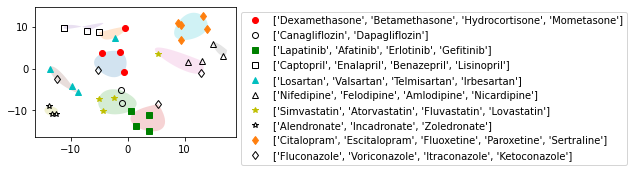

In [49]:
# Drug clustering (Deepwalk-SS)
node_list = ['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone',
'Canagliflozin', 'Dapagliflozin', 
'Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib',
'Captopril', 'Enalapril', 'Benazepril', 'Lisinopril',
'Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan',
'Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine',
'Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin',
'Alendronate', 'Incadronate', 'Zoledronate',
'Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline',
'Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']

label_true = [0,0,0,0,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,8,8,8,8,8,9,9,9,9] 

Node_Lists = [['Dexamethasone', 'Betamethasone', 'Hydrocortisone', 'Mometasone'],
                ['Canagliflozin', 'Dapagliflozin'],
                ['Lapatinib', 'Afatinib', 'Erlotinib', 'Gefitinib'],
                ['Captopril', 'Enalapril', 'Benazepril', 'Lisinopril'],
                ['Losartan', 'Valsartan', 'Telmisartan', 'Irbesartan'],
                ['Nifedipine', 'Felodipine', 'Amlodipine', 'Nicardipine'],
                ['Simvastatin', 'Atorvastatin', 'Fluvastatin', 'Lovastatin'],
                ['Alendronate', 'Incadronate', 'Zoledronate'],
                ['Citalopram', 'Escitalopram', 'Fluoxetine', 'Paroxetine', 'Sertraline'],
                ['Fluconazole', 'Voriconazole', 'Itraconazole', 'Ketoconazole']]

subgraph_dict_SS = subGsHetioDrugSS
subgraph_dict_NS = subGsHetioDrugNS

cluster_df = ClusteringDF(subgraph_dict_SS, node_list, label_true)
tSNEplotSS(cluster_df, Node_Lists)
# plt.savefig('deepwalk_SS.png', dpi=400,
#             bbox_extra_artists=(lgd,), bbox_inches='tight')

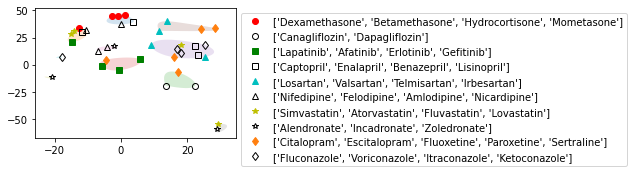

In [48]:
# Drug clustering (Deepwalk-NS)
cluster_df = ClusteringDF(subgraph_dict_NS, node_list, label_true)
tSNEplotNS(cluster_df, Node_Lists)
# plt.savefig('deepwalk_NS.png', dpi=400,
#             bbox_extra_artists=(lgd,), bbox_inches='tight')

## Data needed for Figure 4

Figures 4 and 5 are produced by R (software). See R files for reproducing them.

In [73]:
def TimeToBuildSubgraph(node_list, G, semantic_query, compared_labels):
    times = []
    for node in node_list:
        start = time.time()
        subG = getSubgraph_neo4j(G, node, semantic_query, compared_labels)
        end = time.time()
        times.append(end-start)
    return times

In [75]:
## ROBOKOP (Drugs)
# given G, node_List, user input regex, embedding method(m), walk_length(l), num_walk(r), 
# given compared_labels {only for database includes multiple labels for nodes}, 
# given metapath {if metapath2vec is used}   

# G = the database link
G = "bolt://robokopkg.renci.org" 

# # node_list = a list of nodes of interest
node_list = ['Fluoxetine', 'Paroxetine', 'Sertraline',
            'Felodipine', 'Isradipine', 'Nifedipine',
            'Nilotinib', 'Bosutinib', 'Ponatinib',
            'Dexamethasone', 'Betamethasone', 'Desoximetasone',
            'Promethazine', 'Diphenhydramine', 'Chloropyramine',
            'Omeprazole', 'Pantoprazole',
            'Norethindrone', 'Levonorgestrel', 
            'Apraclonidine', 'Brimonidine', 
            'Glyburide', 'Tolbutamide', 
            'Simvastatin', 'Lovastatin', 'Pravastatin'
            ] 

# semantic_query = user input regular expressions
semantic_query = "`biolink:ChemicalEntity` ? `biolink:Gene` `biolink:causes` `biolink:DiseaseOrPhenotypicFeature`" 

# compared_labels {only for database includes multiple labels for nodes}
compared_label = ["`biolink:ChemicalEntity`", "`biolink:Gene`", "`biolink:DiseaseOrPhenotypicFeature`"]

In [102]:
timeSS = TimeToBuildSubgraph(node_list, G, semantic_query, compared_label)
timeNS1 = TimeToBuildSubgraph(node_list, G, "`biolink:ChemicalEntity` ? ?", compared_label)
timeNS2 = TimeToBuildSubgraph(node_list, G, "`biolink:ChemicalEntity` ? ? ? ?", compared_label)

In [124]:
df = pd.DataFrame({'nodes': node_list,
                   'SS': timeSS,
                   'NS1': timeNS1,
                   'NS2': timeNS2})
#reshape DataFrame from wide format to long format
df = pd.melt(df, id_vars='nodes', value_vars=['SS', 'NS1', 'NS2'])
df.to_csv('runtime.csv', sep='\t')
